In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
#import the data
df = pd.read_csv('RecGym.csv')

In [3]:
#visualizing the dataset
print(df.shape)
print(df.info())
df.describe()

(4703320, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703320 entries, 0 to 4703319
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Subject   int64  
 1   Position  object 
 2   Session   int64  
 3   A_x       float64
 4   A_y       float64
 5   A_z       float64
 6   G_x       float64
 7   G_y       float64
 8   G_z       float64
 9   C_1       float64
 10  Workout   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 394.7+ MB
None


,Subject,Session,A_x,A_y,A_z,G_x,G_y,G_z,C_1
count,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06
mean,5.392574e+00,2.802395e+00,5.035507e-01,4.985131e-01,4.977776e-01,4.997782e-01,4.995451e-01,5.002020e-01,4.999879e-01
std,2.845797e+00,1.441097e+00,4.246173e-02,4.969846e-02,3.060175e-02,4.460991e-02,3.632624e-02,4.586471e-02,4.465815e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,4.965000e-01,4.931250e-01,4.945000e-01,4.931250e-01,4.945312e-01,4.929688e-01,4.977754e-01
50%,5.000000e+00,3.000000e+00,5.000000e-01,4.997500e-01,4.998750e-01,4.999625e-01,5.000000e-01,4.999625e-01,5.000488e-01
75%,8.000000e+00,4.000000e+00,5.056250e-01,5.047500e-01,5.032500e-01,5.064437e-01,5.051937e-01,5.054312e-01,5.025115e-01
max,1.000000e+01,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
# finding amount of sessions for each subject for each workout
session_counts = (
    df.groupby(['Workout', 'Subject'])['Session']
      .nunique()
      .unstack(fill_value=0)
)
print(session_counts)

# Find min number of subjects per workout
min_subjects_per_workout = (
    df.groupby('Workout')['Subject']
      .nunique()
      .min()
)

# Find min sessions per (workout, subject)
min_sessions_per_subject = (
    df.groupby(['Workout', 'Subject'])['Session']
      .nunique()
      .min()
)

print("Minimum subjects per workout:", min_subjects_per_workout)
print("Minimum sessions per subject:", min_sessions_per_subject)


Subject       1   2   3   4   5   6   7   8   9   10
Workout                                             
Adductor       5   5   5   5   5   5   5   5   5   5
ArmCurl        5   5   5   4   5   4   5   5   5   5
BenchPress     5   5   5   5   5   5   5   5   5   5
LegCurl        5   5   5   5   5   5   5   5   5   5
LegPress       5   5   5   5   5   5   5   5   5   5
Null           5   5   5   5   5   5   5   5   5   5
Riding         5   5   5   4   5   5   5   5   5   5
RopeSkipping   5   5   5   4   5   5   5   5   5   5
Running        5   5   5   5   5   5   5   5   5   5
Squat          5   5   5   5   5   5   5   5   5   5
StairClimber   5   5   5   5   5   5   5   5   5   5
Walking        5   5   5   5   5   5   5   5   5   5
Minimum subjects per workout: 10
Minimum sessions per subject: 4


In [5]:
## balancing by subject and session
def balance_by_subject_session(df, label_col='Workout', subj_col='Subject', sess_col='Session',
                               n_subjects=None, n_sessions=None, random_state=42):
    rng = np.random.RandomState(random_state)
    balanced_parts = []

    # Compute defaults if not provided
    if n_subjects is None:
        n_subjects = df.groupby(label_col)[subj_col].nunique().min()
    if n_sessions is None:
        n_sessions = df.groupby([label_col, subj_col])[sess_col].nunique().min()

    # Iterate through each workout
    for workout, g_workout in df.groupby(label_col):
        # Randomly select subjects
        subjects = g_workout[subj_col].unique()
        chosen_subjects = rng.choice(subjects, size=n_subjects, replace=False)

        for subj in chosen_subjects:
            g_subj = g_workout[g_workout[subj_col] == subj]
            sessions = g_subj[sess_col].unique()
            chosen_sessions = rng.choice(sessions, size=n_sessions, replace=False)
            
            # Keep all rows belonging to those sessions
            mask = (df[label_col] == workout) & \
                   (df[subj_col] == subj) & \
                   (df[sess_col].isin(chosen_sessions))
            balanced_parts.append(df[mask])

    balanced_df = pd.concat(balanced_parts).reset_index(drop=True)
    return balanced_df

# feature engineering
feature_df = df.groupby(['Workout', 'Subject', 'Session']).agg({
    'A_x': ['mean', 'std', 'max', 'min', 'median', 'skew'],
    'A_y': ['mean', 'std', 'max', 'min', 'median', 'skew'],
    'A_z': ['mean', 'std', 'max', 'min', 'median', 'skew'],
    'G_x': ['mean', 'std', 'max', 'min', 'median', 'skew'],
    'G_y': ['mean', 'std', 'max', 'min', 'median', 'skew'],
    'G_z': ['mean', 'std', 'max', 'min', 'median', 'skew'],
    'C_1': ['mean', 'std', 'max', 'min', 'median', 'skew'],
})
feature_df.columns = ['_'.join(c) for c in feature_df.columns]
feature_df = feature_df.reset_index()

balanced_df = balance_by_subject_session(feature_df, label_col='Workout', subj_col='Subject', sess_col='Session')

In [6]:
## preparing data
X = balanced_df.drop(columns='Workout')
y = balanced_df['Workout']

#dividing data into training, cross-validation, and test data
#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (288, 44) y_train.shape (288,)
X_cv.shape (96, 44) y_cv.shape (96,)
X_test.shape (96, 44) y_test.shape (96,)


In [7]:
non_feature_cols = ['Subject', 'Session', 'Position']
X_train = X_train.drop(columns=[col for col in non_feature_cols if col in X_train.columns])
X_cv    = X_cv.drop(columns=[col for col in non_feature_cols if col in X_cv.columns])
X_test  = X_test.drop(columns=[col for col in non_feature_cols if col in X_test.columns])

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled    = scaler.transform(X_cv)
X_test_scaled  = scaler.transform(X_test)

print("X_train_scaled.shape", X_train_scaled.shape, "y_train.shape", y_train.shape)
print("X_cv_scaled.shape", X_cv_scaled.shape, "y_cv.shape", y_cv.shape)
print("X_test_scaled.shape", X_test_scaled.shape, "y_test.shape", y_test.shape)

X_train_scaled.shape (288, 42) y_train.shape (288,)
X_cv_scaled.shape (96, 42) y_cv.shape (96,)
X_test_scaled.shape (96, 42) y_test.shape (96,)


In [9]:
num_features = X_train_scaled.shape[1]
num_classes  = len(y_train.unique())

tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.Input(shape=(num_features,)),
        Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="L1"),
        Dense(num_classes, activation="softmax", name="L2")
        
        ### END CODE HERE ###
    ], name = "model_1"
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# encoding y from string to integer labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_cv_encoded = le.transform(y_cv)
y_test_encoded = le.transform(y_test)

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_cv_scaled, y_cv_encoded),
    epochs=500,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            verbose=1
            )
    ],
    verbose=0
)

print(f"Stopped at epoch: {len(history.history['loss'])}")

Epoch 322: early stopping
Restoring model weights from the end of the best epoch: 292.
Stopped at epoch: 322


In [10]:
# Evaluate
train_loss, train_acc = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
val_loss, val_acc = model.evaluate(X_cv_scaled, y_cv_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n" + "="*50)
print("NEURAL NETWORK RESULTS")
print("="*50)
print(f"Train - Loss: {train_loss:.3f}, Accuracy: {train_acc:.3f}")
print(f"Val   - Loss: {val_loss:.3f}, Accuracy: {val_acc:.3f}")
print(f"Test  - Loss: {test_loss:.3f}, Accuracy: {test_acc:.3f}")


NEURAL NETWORK RESULTS
Train - Loss: 0.258, Accuracy: 0.969
Val   - Loss: 0.580, Accuracy: 0.896
Test  - Loss: 0.478, Accuracy: 0.896


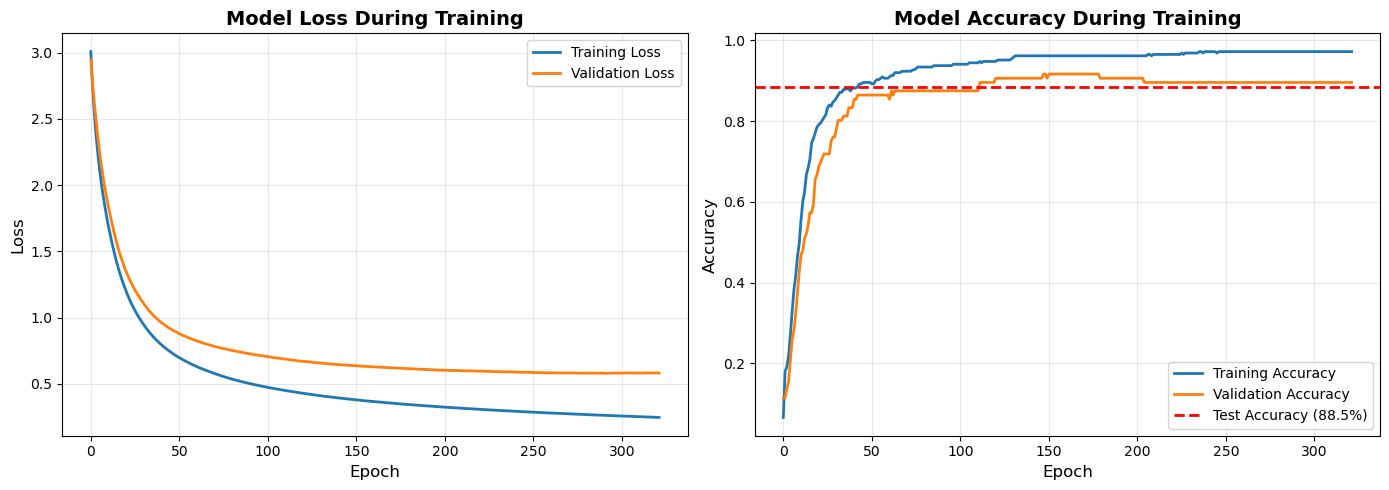

In [11]:
# visualizing the training progress

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.axhline(y=0.885, color='r', linestyle='--', label='Test Accuracy (88.5%)', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

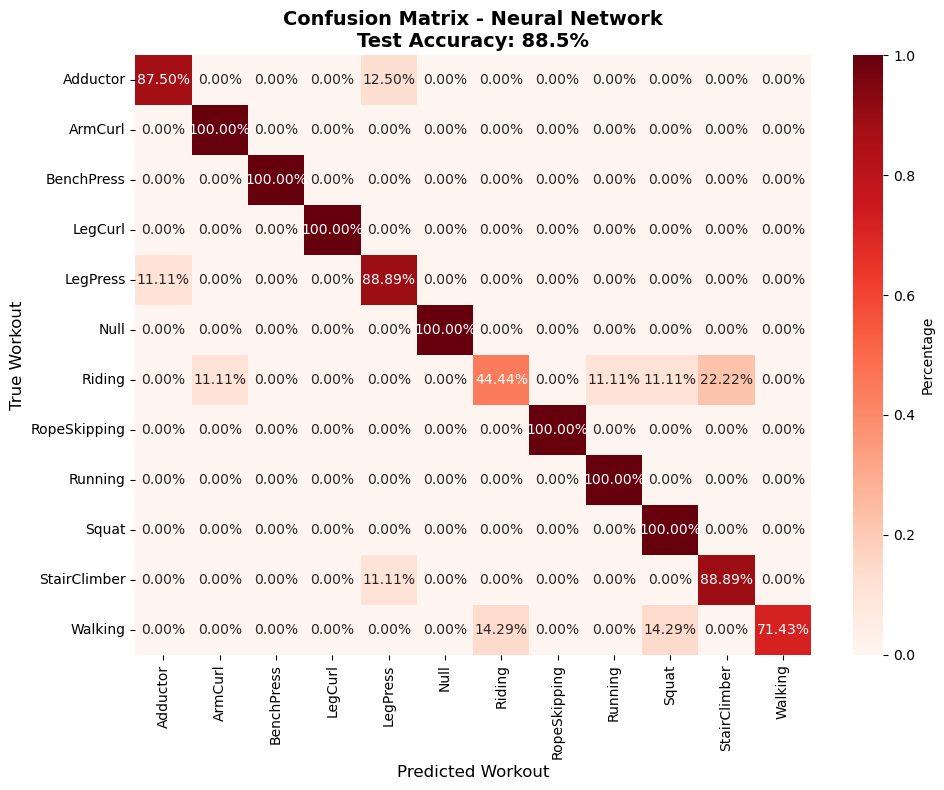


DETAILED CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

    Adductor      0.875     0.875     0.875         8
     ArmCurl      0.857     1.000     0.923         6
  BenchPress      1.000     1.000     1.000         7
     LegCurl      1.000     1.000     1.000         6
    LegPress      0.800     0.889     0.842         9
        Null      1.000     1.000     1.000         8
      Riding      0.800     0.444     0.571         9
RopeSkipping      1.000     1.000     1.000         7
     Running      0.917     1.000     0.957        11
       Squat      0.818     1.000     0.900         9
StairClimber      0.800     0.889     0.842         9
     Walking      1.000     0.714     0.833         7

    accuracy                          0.896        96
   macro avg      0.906     0.901     0.895        96
weighted avg      0.898     0.896     0.888        96


PER-CLASS PERFORMANCE
Adductor            : 87.5% (8 samples)
ArmCurl             : 100.0

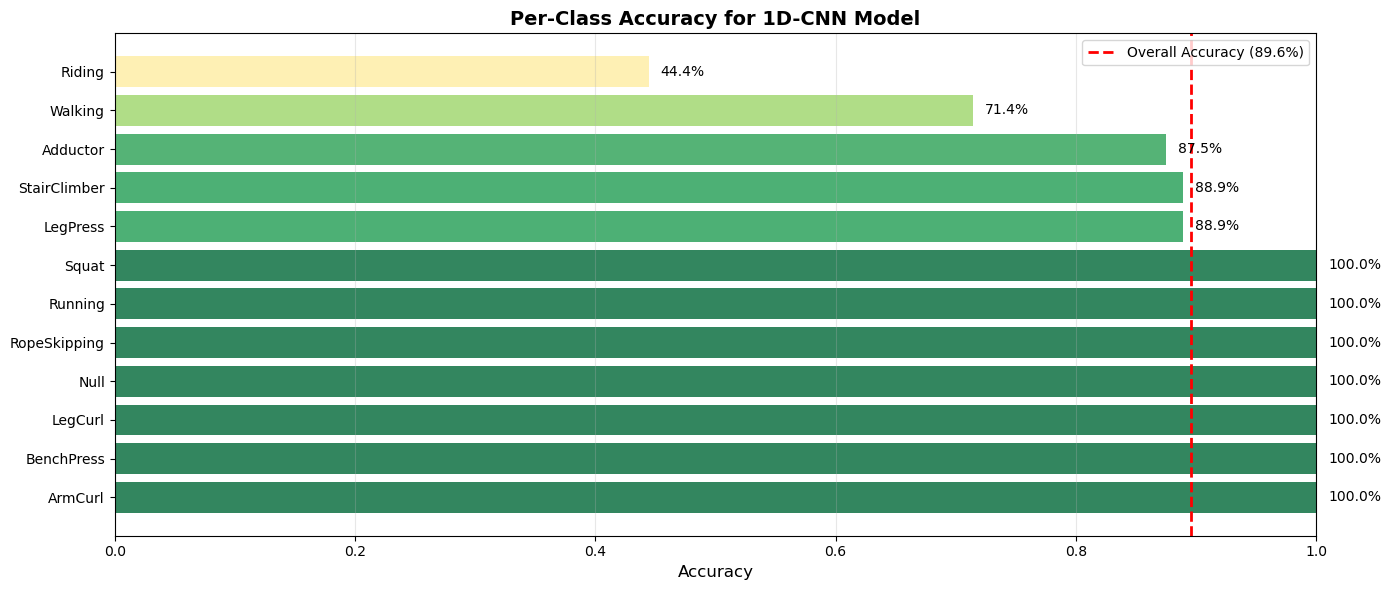

In [12]:
# performance analysis

from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
train_predictions = model.predict(X_train_scaled, verbose=0)
train_pred_classes = np.argmax(train_predictions, axis=1)

val_predictions = model.predict(X_cv_scaled, verbose=0)
val_pred_classes = np.argmax(val_predictions, axis=1)

test_predictions = model.predict(X_test_scaled, verbose=0)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Confusion Matrix for Test Set
cm = confusion_matrix(y_test_encoded, test_pred_classes)

plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Percentage'})
plt.title(f'Confusion Matrix - Neural Network\nTest Accuracy: 88.5%', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Workout', fontsize=12)
plt.xlabel('Predicted Workout', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(y_test_encoded, test_pred_classes, 
                          target_names=le.classes_,
                          digits=3))

# Per-class accuracy
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE")
print("="*60)
for i, workout in enumerate(le.classes_):
    mask = y_test_encoded == i
    if mask.sum() > 0:
        class_acc = (test_pred_classes[mask] == i).sum() / mask.sum()
        print(f"{workout:20s}: {class_acc:.1%} ({mask.sum()} samples)")


# Per-class accuracy analysis
print("\n" + "="*70)
print("PER-CLASS ACCURACY (SORTED BY ACCURACY)")
print("="*70)
per_class_stats = []
for i, workout in enumerate(le.classes_):
    mask = y_test_encoded == i
    if mask.sum() > 0:
        correct = (test_pred_classes[mask] == i).sum()
        total = mask.sum()
        accuracy = correct / total
        per_class_stats.append({
            'Workout': workout,
            'Accuracy': accuracy,
            'Accuracy %': f"{accuracy:.1%}",
            'Correct': correct,
            'Total': total,
            'Errors': total - correct
        })

per_class_df = pd.DataFrame(per_class_stats).sort_values('Accuracy', ascending=False)
print(per_class_df[['Workout', 'Accuracy %', 'Correct', 'Total', 'Errors']].to_string(index=False))

# Identify best and worst performing workouts
print("\n" + "="*70)
print("BEST & WORST PERFORMING WORKOUTS")
print("="*70)
print("\nTop 3 Best:")
print(per_class_df.head(3)[['Workout', 'Accuracy %', 'Total']].to_string(index=False))
print("\nTop 3 Worst:")
print(per_class_df.tail(3)[['Workout', 'Accuracy %', 'Total']].to_string(index=False))

# Most confused workout pairs
print("\n" + "="*70)
print("TOP 15 MOST CONFUSED WORKOUT PAIRS")
print("="*70)

misclassifications = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j and cm[i, j] > 0:
            misclassifications.append({
                'True Workout': le.classes_[i],
                'Predicted As': le.classes_[j],
                'Count': cm[i, j],
                '% of True Class': f"{cm[i, j] / cm[i].sum() * 100:.1f}%"
            })

if misclassifications:
    mis_df = pd.DataFrame(misclassifications).sort_values('Count', ascending=False)
    print(mis_df.head(15).to_string(index=False))
else:
    print("Perfect classification - no errors!")

# Average accuracy across all classes
avg_class_accuracy = per_class_df['Accuracy'].mean()
print(f"\nAverage per-class accuracy: {avg_class_accuracy:.1%}")

# Standard deviation of class accuracies (shows if some classes are much harder)
std_class_accuracy = per_class_df['Accuracy'].std()
print(f"Standard deviation of class accuracies: {std_class_accuracy:.3f}")

if misclassifications:
    most_confused = mis_df.iloc[0]
    print(f"\nMost common confusion: {most_confused['True Workout']} → {most_confused['Predicted As']} ({most_confused['Count']} cases, {most_confused['% of True Class']} of true class)")

# Visualize per-class accuracy
fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.RdYlGn(per_class_df['Accuracy'].values)
bars = ax.barh(per_class_df['Workout'], per_class_df['Accuracy'], color=colors, alpha=0.8)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Per-Class Accuracy for 1D-CNN Model', fontsize=14, fontweight='bold')
ax.axvline(x=test_acc, color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy ({test_acc:.1%})')
ax.set_xlim([0, 1])
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

# Add accuracy labels on bars

for i, (bar, acc) in enumerate(zip(bars, per_class_df['Accuracy'])):
    ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{acc:.1%}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

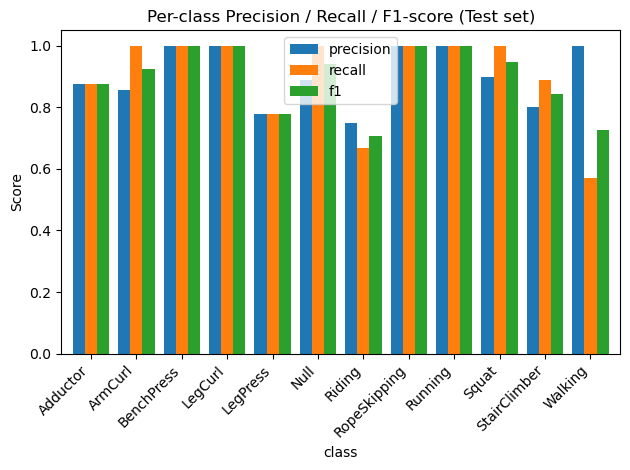

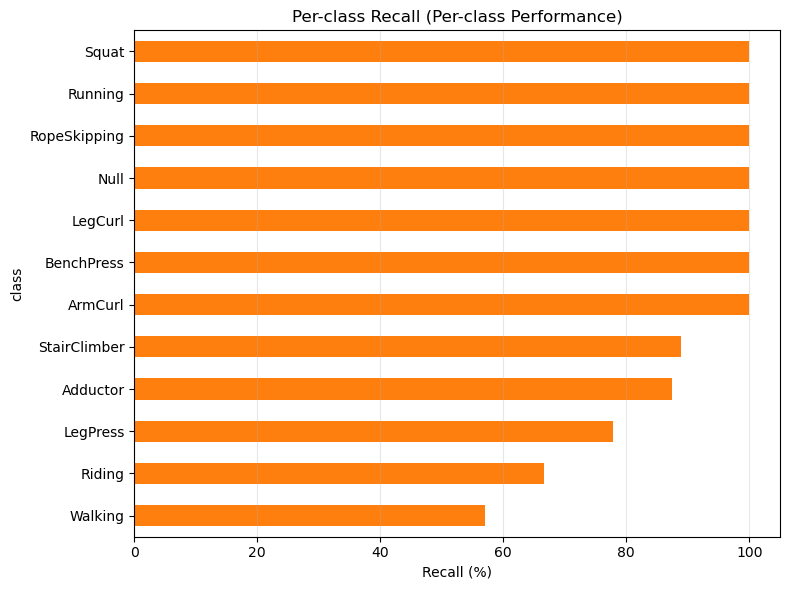

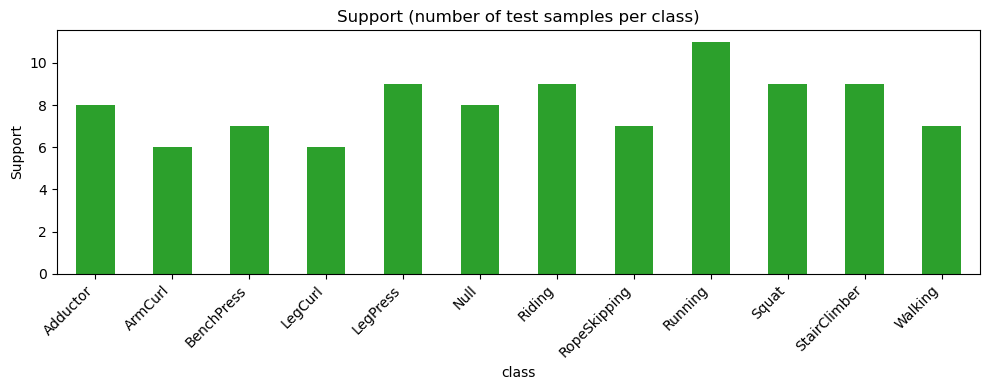

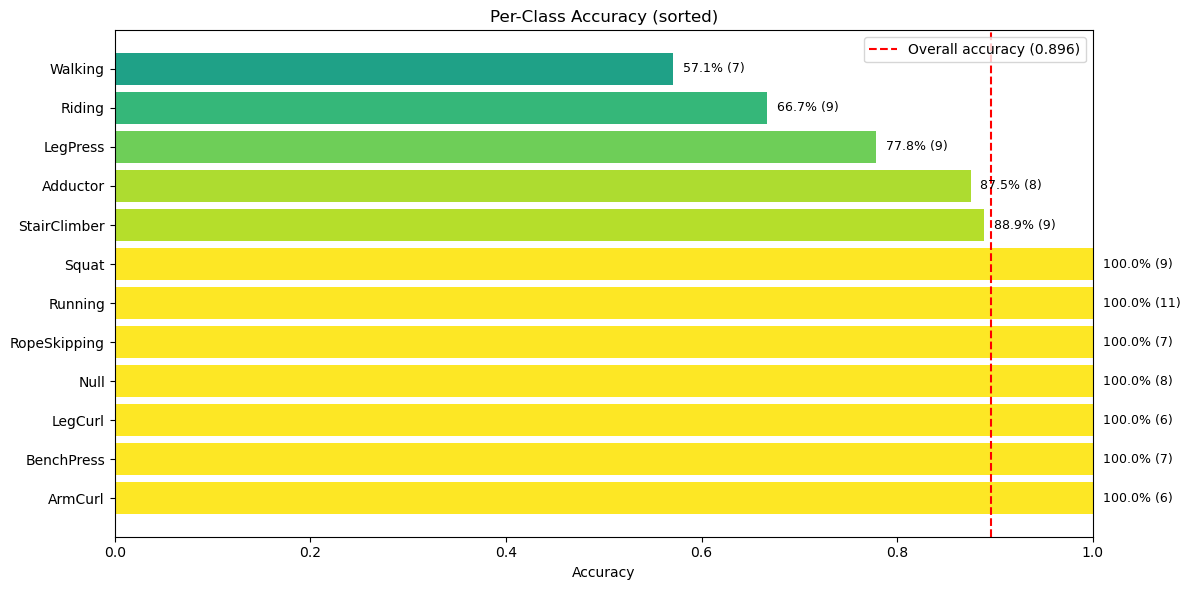

In [14]:


# --- Data: paste the numbers you provided ---
data = {
    'class': ['Adductor','ArmCurl','BenchPress','LegCurl','LegPress','Null','Riding',
              'RopeSkipping','Running','Squat','StairClimber','Walking'],
    'precision':[0.875,0.857,1.000,1.000,0.778,0.889,0.750,1.000,1.000,0.900,0.800,1.000],
    'recall':[0.875,1.000,1.000,1.000,0.778,1.000,0.667,1.000,1.000,1.000,0.889,0.571],
    'f1':[0.875,0.923,1.000,1.000,0.778,0.941,0.706,1.000,1.000,0.947,0.842,0.727],
    'support':[8,6,7,6,9,8,9,7,11,9,9,7]
}
df = pd.DataFrame(data).set_index('class')



# ----- 1) Grouped bar chart: precision / recall / f1 -----
plt.figure(figsize=(12,6))
df[['precision','recall','f1']].plot(kind='bar', width=0.8)
plt.title('Per-class Precision / Recall / F1-score (Test set)')
plt.ylabel('Score')
plt.ylim(0,1.05)
plt.xticks(rotation=45, ha='right')
plt.legend(title='')
plt.tight_layout()
plt.show()

# ----- 2) Per-class recall horizontal bar (Per-class performance) -----
plt.figure(figsize=(8,6))
(df['recall']*100).sort_values().plot(kind='barh', color='C1')
plt.xlabel('Recall (%)')
plt.title('Per-class Recall (Per-class Performance)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ----- 3) Support counts bar -----
plt.figure(figsize=(10,4))
df['support'].plot(kind='bar', color='C2')
plt.title('Support (number of test samples per class)')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----- 4) Per-class accuracy chart (sorted) -----
# Here accuracy per class equals the recall values (true positive / support)
acc_df = df.copy()
acc_df['accuracy'] = acc_df['recall']  # by definition given your report
acc_sorted = acc_df.sort_values('accuracy', ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
colors = plt.cm.viridis(acc_sorted['accuracy'].values)
bars = ax.barh(acc_sorted.index, acc_sorted['accuracy'], color=colors)
ax.set_xlim(0,1)
ax.set_xlabel('Accuracy')
ax.set_title('Per-Class Accuracy (sorted)')

# draw overall accuracy line (from your report)
overall_acc = 0.896  # replace with actual if different
ax.axvline(overall_acc, color='red', linestyle='--', label=f'Overall accuracy ({overall_acc:.3f})')
ax.legend()

# annotate bars with percent and support
for i, (idx, row) in enumerate(acc_sorted.iterrows()):
    ax.text(row['accuracy'] + 0.01, i, f"{row['accuracy']:.1%} ({int(row['support'])})", va='center', fontsize=9)

plt.tight_layout()
plt.show()
